In [1]:
# AeroCNN-II
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import datetime
%matplotlib inline

In [2]:
n_kernel=25
l2Regularizer=1e-09
kernel_size1 = 5
kernel_size2 = 5
#kernel_size3 = 5
n_grid = 101
strides = 1
input_size = 100

In [3]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [4]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [5]:
aa = aa.reshape((133, 16, 1, 1))

In [6]:
os.chdir('D:\\AeroCNN2Inputs')

In [7]:
origin = "D:\\AeroCNN2Inputs"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [8]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [9]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "_alpha"+ str(int(alpha[j])) + ".csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [10]:
image_np = image_df.iloc[:, :].values

In [11]:
image = image_np.reshape((133, 16, 100, 100))

In [12]:
image = 1-image/100

In [13]:
image.shape

(133, 16, 100, 100)

In [14]:
image[0,0,:,:]

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

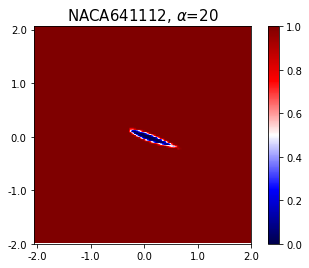

In [154]:
aaa=plt.imshow(image[70,15,:,:].T, cmap='seismic')
plt.title(r'NACA641112, $\alpha$=20', fontsize=15)
values = np.linspace(-2,2,5)
plt.xticks(np.linspace(1,100,5),values)
plt.yticks(np.linspace(100,1,5),values)
plt.colorbar()

In [16]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [17]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [18]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
y = np.hstack((cl, cd))

In [19]:
y = y.reshape((133, 16, 2, 1))

In [20]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [21]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [22]:
geometry.shape

(2128, 1)

In [23]:
geometry = geometry.reshape((133, 16, 1))

In [24]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(image, aa, geometry, y, test_size=0.05, random_state=1)

In [25]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [26]:
x_train.shape

(2016, 100, 100, 1)

In [27]:
input_image = tf.keras.Input(shape=(100, 100, 1))

x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer1')(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size2, kernel_size2), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer2')(x_)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
reshape1 = tf.keras.layers.Flatten()(x_)

x_ = tf.keras.layers.Dense(units=200, activation='relu', name='firstHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(reshape1)
x_ = tf.keras.layers.Dense(units=100, activation='relu', name='secondHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)

output_data = tf.keras.layers.Dense(units=2, activation=None, name='outputLayer')(x_)
output_image = tf.keras.layers.Reshape((2, 1))(output_data)
# AeroCNN-II
model = tf.keras.Model(input_image, output_image)

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 Conv2DLayer1 (Conv2D)       (None, 100, 100, 25)      650       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 25)       0         
 )                                                               
                                                                 
 Conv2DLayer2 (Conv2D)       (None, 50, 50, 25)        15650     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 25)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 15625)             0     

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [30]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, epochs=5000, shuffle=True)
end = datetime.datetime.now()

Epoch 1/5000
63/63 [==============================] - 3s 6ms/step - loss: 0.1914 - rmse: 0.4374
Epoch 2/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0171 - rmse: 0.1306
Epoch 3/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0131 - rmse: 0.1146
Epoch 4/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0132 - rmse: 0.1148
Epoch 5/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0108 - rmse: 0.1038
Epoch 6/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0106 - rmse: 0.1030
Epoch 7/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0087 - rmse: 0.0935
Epoch 8/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0094 - rmse: 0.0969
Epoch 9/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0084 - rmse: 0.0914
Epoch 10/5000
63/63 [==============================] - 0s 7ms/step - loss: 0.0077 - rmse: 0.0879
Epoch 11/5000
63/63 [==================

63/63 [==============================] - 0s 5ms/step - loss: 0.0058 - rmse: 0.0761
Epoch 86/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0062 - rmse: 0.0789
Epoch 87/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0057 - rmse: 0.0754
Epoch 88/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0057 - rmse: 0.0754
Epoch 89/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0058 - rmse: 0.0758
Epoch 90/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0057 - rmse: 0.0753
Epoch 91/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0054 - rmse: 0.0736
Epoch 92/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0062 - rmse: 0.0789
Epoch 93/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0055 - rmse: 0.0742
Epoch 94/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0057 - rmse: 0.0754
Epoch 95/5000
63/63 [=======================

63/63 [==============================] - 0s 5ms/step - loss: 0.0048 - rmse: 0.0694
Epoch 169/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0049 - rmse: 0.0697
Epoch 170/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0047 - rmse: 0.0684
Epoch 171/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0044 - rmse: 0.0665
Epoch 172/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0047 - rmse: 0.0685
Epoch 173/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0045 - rmse: 0.0673
Epoch 174/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0046 - rmse: 0.0677
Epoch 175/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0046 - rmse: 0.0676
Epoch 176/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0051 - rmse: 0.0717
Epoch 177/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0048 - rmse: 0.0692
Epoch 178/5000
63/63 [=============

63/63 [==============================] - 0s 5ms/step - loss: 0.0036 - rmse: 0.0600
Epoch 252/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0037 - rmse: 0.0609
Epoch 253/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0037 - rmse: 0.0606
Epoch 254/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0035 - rmse: 0.0587
Epoch 255/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0036 - rmse: 0.0601
Epoch 256/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0036 - rmse: 0.0604
Epoch 257/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0040 - rmse: 0.0629
Epoch 258/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0037 - rmse: 0.0610
Epoch 259/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0038 - rmse: 0.0617
Epoch 260/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0035 - rmse: 0.0591
Epoch 261/5000
63/63 [=============

63/63 [==============================] - 0s 5ms/step - loss: 0.0031 - rmse: 0.0556
Epoch 335/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0029 - rmse: 0.0537
Epoch 336/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0029 - rmse: 0.0534
Epoch 337/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0029 - rmse: 0.0543
Epoch 338/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0031 - rmse: 0.0554
Epoch 339/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0031 - rmse: 0.0559
Epoch 340/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0029 - rmse: 0.0538
Epoch 341/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0029 - rmse: 0.0543
Epoch 342/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0030 - rmse: 0.0551
Epoch 343/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0030 - rmse: 0.0547
Epoch 344/5000
63/63 [=============

63/63 [==============================] - 0s 5ms/step - loss: 0.0023 - rmse: 0.0479
Epoch 418/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0025 - rmse: 0.0503
Epoch 419/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0023 - rmse: 0.0480
Epoch 420/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0027 - rmse: 0.0515
Epoch 421/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0024 - rmse: 0.0488
Epoch 422/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0023 - rmse: 0.0477
Epoch 423/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0024 - rmse: 0.0486
Epoch 424/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0024 - rmse: 0.0493
Epoch 425/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0025 - rmse: 0.0497
Epoch 426/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0024 - rmse: 0.0495
Epoch 427/5000
63/63 [=============

63/63 [==============================] - 0s 5ms/step - loss: 0.0021 - rmse: 0.0457
Epoch 501/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0022 - rmse: 0.0474
Epoch 502/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0021 - rmse: 0.0462
Epoch 503/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0021 - rmse: 0.0459
Epoch 504/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0020 - rmse: 0.0443
Epoch 505/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0021 - rmse: 0.0455
Epoch 506/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0020 - rmse: 0.0452
Epoch 507/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0020 - rmse: 0.0446
Epoch 508/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0020 - rmse: 0.0452
Epoch 509/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0022 - rmse: 0.0466
Epoch 510/5000
63/63 [=============

63/63 [==============================] - 0s 5ms/step - loss: 0.0018 - rmse: 0.0424
Epoch 584/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0418
Epoch 585/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0410
Epoch 586/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0395
Epoch 587/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0405
Epoch 588/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0018 - rmse: 0.0421
Epoch 589/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0018 - rmse: 0.0420
Epoch 590/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0404
Epoch 591/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0405
Epoch 592/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0412
Epoch 593/5000
63/63 [=============

63/63 [==============================] - 0s 5ms/step - loss: 0.0014 - rmse: 0.0373
Epoch 667/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0014 - rmse: 0.0376
Epoch 668/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.0382
Epoch 669/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.0384
Epoch 670/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.0389
Epoch 671/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.0384
Epoch 672/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0365
Epoch 673/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0405
Epoch 674/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0411
Epoch 675/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.0391
Epoch 676/5000
63/63 [=============

63/63 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0355
Epoch 750/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.0394
Epoch 751/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0363
Epoch 752/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0351
Epoch 753/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0345
Epoch 754/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0342
Epoch 755/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.0387
Epoch 756/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.0390
Epoch 757/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0345
Epoch 758/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0341
Epoch 759/5000
63/63 [=============

63/63 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0335
Epoch 833/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0320
Epoch 834/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.8421e-04 - rmse: 0.0314
Epoch 835/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0321
Epoch 836/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.9565e-04 - rmse: 0.0299
Epoch 837/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.4526e-04 - rmse: 0.0307
Epoch 838/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0360
Epoch 839/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0362
Epoch 840/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.4418e-04 - rmse: 0.0307
Epoch 841/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.7924e-04 - rmse: 0.0296
Epoch 842/5000


63/63 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0339
Epoch 915/5000
63/63 [==============================] - 0s 6ms/step - loss: 9.8668e-04 - rmse: 0.0314
Epoch 916/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.9818e-04 - rmse: 0.0316
Epoch 917/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.1863e-04 - rmse: 0.0303
Epoch 918/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.5287e-04 - rmse: 0.0292
Epoch 919/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.8945e-04 - rmse: 0.0298
Epoch 920/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.4575e-04 - rmse: 0.0291
Epoch 921/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.7442e-04 - rmse: 0.0296
Epoch 922/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.6141e-04 - rmse: 0.0276
Epoch 923/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.5112e-04 - rmse: 0.0274

63/63 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0356
Epoch 996/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0348
Epoch 997/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0316
Epoch 998/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.8249e-04 - rmse: 0.0297
Epoch 999/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.0175e-04 - rmse: 0.0265
Epoch 1000/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.0030e-04 - rmse: 0.0264
Epoch 1001/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.4305e-04 - rmse: 0.0272
Epoch 1002/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.9075e-04 - rmse: 0.0281
Epoch 1003/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.1471e-04 - rmse: 0.0285
Epoch 1004/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.6666e-04 - rmse: 0.0277
Ep

63/63 [==============================] - 0s 5ms/step - loss: 7.4355e-04 - rmse: 0.0273
Epoch 1076/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.3797e-04 - rmse: 0.0271
Epoch 1077/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.4422e-04 - rmse: 0.0290
Epoch 1078/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.0142e-04 - rmse: 0.0265
Epoch 1079/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.6241e-04 - rmse: 0.0257
Epoch 1080/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.6995e-04 - rmse: 0.0259
Epoch 1081/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.7628e-04 - rmse: 0.0278
Epoch 1082/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.8281e-04 - rmse: 0.0261
Epoch 1083/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.8340e-04 - rmse: 0.0261
Epoch 1084/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.6218e-04 -

Epoch 1155/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.2566e-04 - rmse: 0.0250
Epoch 1156/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.2488e-04 - rmse: 0.0250
Epoch 1157/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.2450e-04 - rmse: 0.0250
Epoch 1158/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.6189e-04 - rmse: 0.0293
Epoch 1159/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.0393
Epoch 1160/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0335
Epoch 1161/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.7183e-04 - rmse: 0.0295
Epoch 1162/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.8809e-04 - rmse: 0.0281
Epoch 1163/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.7929e-04 - rmse: 0.0279
Epoch 1164/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.02

63/63 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0337
Epoch 1235/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.9981e-04 - rmse: 0.0283
Epoch 1236/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.4090e-04 - rmse: 0.0253
Epoch 1237/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.9855e-04 - rmse: 0.0264
Epoch 1238/5000
63/63 [==============================] - 0s 6ms/step - loss: 5.7368e-04 - rmse: 0.0239
Epoch 1239/5000
63/63 [==============================] - 0s 6ms/step - loss: 6.0708e-04 - rmse: 0.0246
Epoch 1240/5000
63/63 [==============================] - 0s 6ms/step - loss: 5.8618e-04 - rmse: 0.0242
Epoch 1241/5000
63/63 [==============================] - 0s 6ms/step - loss: 6.4298e-04 - rmse: 0.0253
Epoch 1242/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.0796e-04 - rmse: 0.0246
Epoch 1243/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.1346e-04 - rms

63/63 [==============================] - 0s 5ms/step - loss: 7.1454e-04 - rmse: 0.0267
Epoch 1314/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.6259e-04 - rmse: 0.0237
Epoch 1315/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.8175e-04 - rmse: 0.0241
Epoch 1316/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.4546e-04 - rmse: 0.0233
Epoch 1317/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.4665e-04 - rmse: 0.0234
Epoch 1318/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.1061e-04 - rmse: 0.0226
Epoch 1319/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.9305e-04 - rmse: 0.0222
Epoch 1320/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.4699e-04 - rmse: 0.0234
Epoch 1321/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.3583e-04 - rmse: 0.0252
Epoch 1322/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.7481e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 6.6401e-04 - rmse: 0.0257
Epoch 1393/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.4993e-04 - rmse: 0.0255
Epoch 1394/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.0907e-04 - rmse: 0.0247
Epoch 1395/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.9876e-04 - rmse: 0.0264
Epoch 1396/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.7302e-04 - rmse: 0.0239
Epoch 1397/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.1134e-04 - rmse: 0.0247
Epoch 1398/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.7651e-04 - rmse: 0.0240
Epoch 1399/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.1042e-04 - rmse: 0.0247
Epoch 1400/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.1058e-04 - rmse: 0.0226
Epoch 1401/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.7396e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 6.8025e-04 - rmse: 0.0261
Epoch 1472/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.8750e-04 - rmse: 0.0242
Epoch 1473/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.6476e-04 - rmse: 0.0237
Epoch 1474/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.1510e-04 - rmse: 0.0248
Epoch 1475/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.5060e-04 - rmse: 0.0255
Epoch 1476/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.4486e-04 - rmse: 0.0233
Epoch 1477/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.6374e-04 - rmse: 0.0237
Epoch 1478/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.0449e-04 - rmse: 0.0246
Epoch 1479/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.1277e-04 - rmse: 0.0247
Epoch 1480/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.8690e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 6.9869e-04 - rmse: 0.0264
Epoch 1551/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.7268e-04 - rmse: 0.0259
Epoch 1552/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.7703e-04 - rmse: 0.0260
Epoch 1553/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.9852e-04 - rmse: 0.0223
Epoch 1554/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.6698e-04 - rmse: 0.0216
Epoch 1555/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.8153e-04 - rmse: 0.0241
Epoch 1556/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.8066e-04 - rmse: 0.0219
Epoch 1557/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.8964e-04 - rmse: 0.0221
Epoch 1558/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.9887e-04 - rmse: 0.0223
Epoch 1559/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.5166e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 4.8211e-04 - rmse: 0.0219
Epoch 1630/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.8362e-04 - rmse: 0.0220
Epoch 1631/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.2836e-04 - rmse: 0.0230
Epoch 1632/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.9786e-04 - rmse: 0.0223
Epoch 1633/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.8251e-04 - rmse: 0.0219
Epoch 1634/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.5112e-04 - rmse: 0.0234
Epoch 1635/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.9007e-04 - rmse: 0.0243
Epoch 1636/5000
63/63 [==============================] - 0s 6ms/step - loss: 5.4423e-04 - rmse: 0.0233
Epoch 1637/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.4872e-04 - rmse: 0.0254
Epoch 1638/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.6102e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 5.4202e-04 - rmse: 0.0233
Epoch 1709/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.3199e-04 - rmse: 0.0251
Epoch 1710/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.5077e-04 - rmse: 0.0255
Epoch 1711/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.8151e-04 - rmse: 0.0241
Epoch 1712/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.2543e-04 - rmse: 0.0229
Epoch 1713/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.8118e-04 - rmse: 0.0219
Epoch 1714/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.9218e-04 - rmse: 0.0243
Epoch 1715/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.4500e-04 - rmse: 0.0233
Epoch 1716/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.7235e-04 - rmse: 0.0239
Epoch 1717/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.6743e-04 -

63/63 [==============================] - 0s 6ms/step - loss: 5.2721e-04 - rmse: 0.0229
Epoch 1788/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.4497e-04 - rmse: 0.0233
Epoch 1789/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.8640e-04 - rmse: 0.0220
Epoch 1790/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.8689e-04 - rmse: 0.0242
Epoch 1791/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.4567e-04 - rmse: 0.0211
Epoch 1792/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.9789e-04 - rmse: 0.0199
Epoch 1793/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.7900e-04 - rmse: 0.0219
Epoch 1794/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.9790e-04 - rmse: 0.0244
Epoch 1795/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.1919e-04 - rmse: 0.0228
Epoch 1796/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.8004e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 6.3483e-04 - rmse: 0.0252
Epoch 1867/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.7674e-04 - rmse: 0.0240
Epoch 1868/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.2546e-04 - rmse: 0.0229
Epoch 1869/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.4502e-04 - rmse: 0.0211
Epoch 1870/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.3233e-04 - rmse: 0.0230
Epoch 1871/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.9051e-04 - rmse: 0.0221
Epoch 1872/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.5422e-04 - rmse: 0.0309
Epoch 1873/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.6661e-04 - rmse: 0.0277
Epoch 1874/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.7464e-04 - rmse: 0.0218
Epoch 1875/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.7945e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 6.2395e-04 - rmse: 0.0249
Epoch 1946/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.1813e-04 - rmse: 0.0227
Epoch 1947/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.3517e-04 - rmse: 0.0231
Epoch 1948/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.3341e-04 - rmse: 0.0231
Epoch 1949/5000
63/63 [==============================] - 0s 6ms/step - loss: 5.1510e-04 - rmse: 0.0227
Epoch 1950/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.0148e-04 - rmse: 0.0200
Epoch 1951/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.2782e-04 - rmse: 0.0304
Epoch 1952/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0010 - rmse: 0.0318
Epoch 1953/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.5850e-04 - rmse: 0.0275
Epoch 1954/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.9267e-04 - rms

63/63 [==============================] - 0s 5ms/step - loss: 4.5202e-04 - rmse: 0.0212
Epoch 2025/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.7038e-04 - rmse: 0.0192
Epoch 2026/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.2910e-04 - rmse: 0.0207
Epoch 2027/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.0160e-04 - rmse: 0.0200
Epoch 2028/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.6412e-04 - rmse: 0.0215
Epoch 2029/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.2066e-04 - rmse: 0.0205
Epoch 2030/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.9359e-04 - rmse: 0.0263
Epoch 2031/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.2097e-04 - rmse: 0.0228
Epoch 2032/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.0569e-04 - rmse: 0.0201
Epoch 2033/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.2581e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 4.6249e-04 - rmse: 0.0215
Epoch 2104/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.5448e-04 - rmse: 0.0213
Epoch 2105/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.6639e-04 - rmse: 0.0216
Epoch 2106/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.1104e-04 - rmse: 0.0202
Epoch 2107/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0039 - rmse: 0.0628
Epoch 2108/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0018 - rmse: 0.0426
Epoch 2109/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.7288e-04 - rmse: 0.0295
Epoch 2110/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.7910e-04 - rmse: 0.0219
Epoch 2111/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.8247e-04 - rmse: 0.0195
Epoch 2112/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.9031e-04 - rmse: 0

63/63 [==============================] - 0s 5ms/step - loss: 3.6562e-04 - rmse: 0.0191
Epoch 2183/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3758e-04 - rmse: 0.0183
Epoch 2184/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.8855e-04 - rmse: 0.0197
Epoch 2185/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.8103e-04 - rmse: 0.0219
Epoch 2186/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.9528e-04 - rmse: 0.0198
Epoch 2187/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.4649e-04 - rmse: 0.0186
Epoch 2188/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.5625e-04 - rmse: 0.0188
Epoch 2189/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.7587e-04 - rmse: 0.0193
Epoch 2190/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.7241e-04 - rmse: 0.0193
Epoch 2191/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.5046e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 3.7632e-04 - rmse: 0.0194
Epoch 2262/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.0095e-04 - rmse: 0.0264
Epoch 2263/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.2393e-04 - rmse: 0.0205
Epoch 2264/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.7743e-04 - rmse: 0.0194
Epoch 2265/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.6480e-04 - rmse: 0.0215
Epoch 2266/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.1690e-04 - rmse: 0.0204
Epoch 2267/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.9341e-04 - rmse: 0.0198
Epoch 2268/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.0557e-04 - rmse: 0.0201
Epoch 2269/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.8186e-04 - rmse: 0.0195
Epoch 2270/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.6784e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 4.0849e-04 - rmse: 0.0202
Epoch 2341/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.1472e-04 - rmse: 0.0203
Epoch 2342/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3338e-04 - rmse: 0.0182
Epoch 2343/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3789e-04 - rmse: 0.0183
Epoch 2344/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.2408e-04 - rmse: 0.0206
Epoch 2345/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.3573e-04 - rmse: 0.0271
Epoch 2346/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.1179e-04 - rmse: 0.0226
Epoch 2347/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.7561e-04 - rmse: 0.0193
Epoch 2348/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.6697e-04 - rmse: 0.0191
Epoch 2349/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.8989e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 3.9642e-04 - rmse: 0.0199
Epoch 2420/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.9698e-04 - rmse: 0.0244
Epoch 2421/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.1405e-04 - rmse: 0.0267
Epoch 2422/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.7729e-04 - rmse: 0.0240
Epoch 2423/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.7800e-04 - rmse: 0.0218
Epoch 2424/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.2339e-04 - rmse: 0.0205
Epoch 2425/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.0907e-04 - rmse: 0.0202
Epoch 2426/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.6949e-04 - rmse: 0.0192
Epoch 2427/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.8805e-04 - rmse: 0.0197
Epoch 2428/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.7075e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 5.1024e-04 - rmse: 0.0225
Epoch 2499/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.2945e-04 - rmse: 0.0251
Epoch 2500/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.4258e-04 - rmse: 0.0210
Epoch 2501/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.5579e-04 - rmse: 0.0188
Epoch 2502/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.5825e-04 - rmse: 0.0189
Epoch 2503/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.4500e-04 - rmse: 0.0185
Epoch 2504/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2403e-04 - rmse: 0.0179
Epoch 2505/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.3478e-04 - rmse: 0.0208
Epoch 2506/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.2127e-04 - rmse: 0.0205
Epoch 2507/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.4650e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 3.9338e-04 - rmse: 0.0198
Epoch 2578/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.5256e-04 - rmse: 0.0187
Epoch 2579/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.6778e-04 - rmse: 0.0191
Epoch 2580/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.1361e-04 - rmse: 0.0203
Epoch 2581/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.9733e-04 - rmse: 0.0199
Epoch 2582/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3505e-04 - rmse: 0.0183
Epoch 2583/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3805e-04 - rmse: 0.0183
Epoch 2584/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.9920e-04 - rmse: 0.0199
Epoch 2585/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.0616e-04 - rmse: 0.0201
Epoch 2586/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.4879e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 4.2428e-04 - rmse: 0.0206
Epoch 2657/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.6277e-04 - rmse: 0.0237
Epoch 2658/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.4564e-04 - rmse: 0.0211
Epoch 2659/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.8134e-04 - rmse: 0.0195
Epoch 2660/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.1876e-04 - rmse: 0.0178
Epoch 2661/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3314e-04 - rmse: 0.0182
Epoch 2662/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.3558e-04 - rmse: 0.0208
Epoch 2663/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.4077e-04 - rmse: 0.0184
Epoch 2664/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3679e-04 - rmse: 0.0183
Epoch 2665/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2312e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 3.3184e-04 - rmse: 0.0182
Epoch 2736/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.9903e-04 - rmse: 0.0199
Epoch 2737/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2766e-04 - rmse: 0.0180
Epoch 2738/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.6075e-04 - rmse: 0.0189
Epoch 2739/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.5485e-04 - rmse: 0.0188
Epoch 2740/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.9046e-04 - rmse: 0.0197
Epoch 2741/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.6003e-04 - rmse: 0.0189
Epoch 2742/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.7775e-04 - rmse: 0.0194
Epoch 2743/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.6945e-04 - rmse: 0.0192
Epoch 2744/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3292e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 5.3522e-04 - rmse: 0.0231
Epoch 2815/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.8394e-04 - rmse: 0.0195
Epoch 2816/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.0823e-04 - rmse: 0.0175
Epoch 2817/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5953e-04 - rmse: 0.0160
Epoch 2818/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.5810e-04 - rmse: 0.0214
Epoch 2819/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.0276e-04 - rmse: 0.0200
Epoch 2820/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.7461e-04 - rmse: 0.0193
Epoch 2821/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.1750e-04 - rmse: 0.0178
Epoch 2822/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.1046e-04 - rmse: 0.0176
Epoch 2823/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3667e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 5.2528e-04 - rmse: 0.0229
Epoch 2894/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.5102e-04 - rmse: 0.0212
Epoch 2895/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.4201e-04 - rmse: 0.0184
Epoch 2896/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.2121e-04 - rmse: 0.0228
Epoch 2897/5000
63/63 [==============================] - 0s 5ms/step - loss: 6.6910e-04 - rmse: 0.0258
Epoch 2898/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.4492e-04 - rmse: 0.0185
Epoch 2899/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3947e-04 - rmse: 0.0184
Epoch 2900/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2692e-04 - rmse: 0.0180
Epoch 2901/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8217e-04 - rmse: 0.0167
Epoch 2902/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.9005e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 3.4811e-04 - rmse: 0.0186
Epoch 2973/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.1022e-04 - rmse: 0.0176
Epoch 2974/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.1181e-04 - rmse: 0.0176
Epoch 2975/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8392e-04 - rmse: 0.0168
Epoch 2976/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.6154e-04 - rmse: 0.0161
Epoch 2977/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8116e-04 - rmse: 0.0167
Epoch 2978/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.6695e-04 - rmse: 0.0163
Epoch 2979/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4772e-04 - rmse: 0.0157
Epoch 2980/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.7399e-04 - rmse: 0.0165
Epoch 2981/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.7228e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 2.8243e-04 - rmse: 0.0167
Epoch 3052/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5050e-04 - rmse: 0.0158
Epoch 3053/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.9111e-04 - rmse: 0.0170
Epoch 3054/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.0040e-04 - rmse: 0.0173
Epoch 3055/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.9983e-04 - rmse: 0.0173
Epoch 3056/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5939e-04 - rmse: 0.0160
Epoch 3057/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.9758e-04 - rmse: 0.0172
Epoch 3058/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8958e-04 - rmse: 0.0170
Epoch 3059/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8130e-04 - rmse: 0.0167
Epoch 3060/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.6727e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 3.0496e-04 - rmse: 0.0174
Epoch 3131/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2227e-04 - rmse: 0.0179
Epoch 3132/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.1708e-04 - rmse: 0.0204
Epoch 3133/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.6663e-04 - rmse: 0.0191
Epoch 3134/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.9241e-04 - rmse: 0.0221
Epoch 3135/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3405e-04 - rmse: 0.0182
Epoch 3136/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2260e-04 - rmse: 0.0179
Epoch 3137/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.5663e-04 - rmse: 0.0188
Epoch 3138/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.8003e-04 - rmse: 0.0194
Epoch 3139/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3928e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 8.5408e-04 - rmse: 0.0292
Epoch 3210/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.2924e-04 - rmse: 0.0207
Epoch 3211/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.0579e-04 - rmse: 0.0174
Epoch 3212/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.5824e-04 - rmse: 0.0160
Epoch 3213/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.6558e-04 - rmse: 0.0162
Epoch 3214/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3320e-04 - rmse: 0.0152
Epoch 3215/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3557e-04 - rmse: 0.0153
Epoch 3216/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3297e-04 - rmse: 0.0152
Epoch 3217/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5459e-04 - rmse: 0.0159
Epoch 3218/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3889e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 2.7085e-04 - rmse: 0.0164
Epoch 3289/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2102e-04 - rmse: 0.0179
Epoch 3290/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4784e-04 - rmse: 0.0157
Epoch 3291/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.1573e-04 - rmse: 0.0177
Epoch 3292/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.9190e-04 - rmse: 0.0170
Epoch 3293/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.9264e-04 - rmse: 0.0170
Epoch 3294/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.9716e-04 - rmse: 0.0172
Epoch 3295/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.6426e-04 - rmse: 0.0190
Epoch 3296/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8946e-04 - rmse: 0.0169
Epoch 3297/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2582e-04 -

Epoch 3368/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.2995e-04 - rmse: 0.0151
Epoch 3369/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.7669e-04 - rmse: 0.0166
Epoch 3370/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.7895e-04 - rmse: 0.0166
Epoch 3371/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.3474e-04 - rmse: 0.0152
Epoch 3372/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4318e-04 - rmse: 0.0155
Epoch 3373/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4919e-04 - rmse: 0.0157
Epoch 3374/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4907e-04 - rmse: 0.0157
Epoch 3375/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5529e-04 - rmse: 0.0159
Epoch 3376/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.0768e-04 - rmse: 0.0175
Epoch 3377/5000
63/63 [==============================] - 0s 5ms/step - lo

63/63 [==============================] - 0s 5ms/step - loss: 2.8139e-04 - rmse: 0.0167
Epoch 3448/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2089e-04 - rmse: 0.0178
Epoch 3449/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.5203e-04 - rmse: 0.0212
Epoch 3450/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.3299e-04 - rmse: 0.0208
Epoch 3451/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.1251e-04 - rmse: 0.0203
Epoch 3452/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2918e-04 - rmse: 0.0181
Epoch 3453/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3165e-04 - rmse: 0.0181
Epoch 3454/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8874e-04 - rmse: 0.0169
Epoch 3455/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8089e-04 - rmse: 0.0167
Epoch 3456/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.9533e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 3.8289e-04 - rmse: 0.0195
Epoch 3527/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.0328e-04 - rmse: 0.0173
Epoch 3528/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.7920e-04 - rmse: 0.0166
Epoch 3529/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.9049e-04 - rmse: 0.0170
Epoch 3530/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5452e-04 - rmse: 0.0159
Epoch 3531/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8684e-04 - rmse: 0.0169
Epoch 3532/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.7214e-04 - rmse: 0.0164
Epoch 3533/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4845e-04 - rmse: 0.0157
Epoch 3534/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.9816e-04 - rmse: 0.0172
Epoch 3535/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.1710e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.0386
Epoch 3606/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0014 - rmse: 0.0372
Epoch 3607/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.3419e-04 - rmse: 0.0271
Epoch 3608/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.3861e-04 - rmse: 0.0209
Epoch 3609/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.5198e-04 - rmse: 0.0187
Epoch 3610/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.1867e-04 - rmse: 0.0227
Epoch 3611/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.6020e-04 - rmse: 0.0189
Epoch 3612/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.4177e-04 - rmse: 0.0210
Epoch 3613/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2575e-04 - rmse: 0.0180
Epoch 3614/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2651e-04 - rmse: 0

63/63 [==============================] - 0s 5ms/step - loss: 2.3368e-04 - rmse: 0.0152
Epoch 3685/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4457e-04 - rmse: 0.0156
Epoch 3686/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.6925e-04 - rmse: 0.0163
Epoch 3687/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3943e-04 - rmse: 0.0154
Epoch 3688/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4901e-04 - rmse: 0.0157
Epoch 3689/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3686e-04 - rmse: 0.0153
Epoch 3690/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5043e-04 - rmse: 0.0157
Epoch 3691/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5976e-04 - rmse: 0.0160
Epoch 3692/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.8568e-04 - rmse: 0.0168
Epoch 3693/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8007e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 6.6224e-04 - rmse: 0.0257
Epoch 3764/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.8382e-04 - rmse: 0.0195
Epoch 3765/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.7406e-04 - rmse: 0.0165
Epoch 3766/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.2745e-04 - rmse: 0.0150
Epoch 3767/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.7033e-04 - rmse: 0.0164
Epoch 3768/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3518e-04 - rmse: 0.0153
Epoch 3769/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.2518e-04 - rmse: 0.0149
Epoch 3770/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4847e-04 - rmse: 0.0157
Epoch 3771/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3791e-04 - rmse: 0.0153
Epoch 3772/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3453e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 3.2438e-04 - rmse: 0.0179
Epoch 3843/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.7077e-04 - rmse: 0.0164
Epoch 3844/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.9999e-04 - rmse: 0.0199
Epoch 3845/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.8541e-04 - rmse: 0.0196
Epoch 3846/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.3655e-04 - rmse: 0.0208
Epoch 3847/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.8804e-04 - rmse: 0.0196
Epoch 3848/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.0257e-04 - rmse: 0.0173
Epoch 3849/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.6432e-04 - rmse: 0.0162
Epoch 3850/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.6779e-04 - rmse: 0.0216
Epoch 3851/5000
63/63 [==============================] - 0s 5ms/step - loss: 8.2875e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 3.6052e-04 - rmse: 0.0189
Epoch 3922/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.1412e-04 - rmse: 0.0203
Epoch 3923/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.0041e-04 - rmse: 0.0173
Epoch 3924/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8521e-04 - rmse: 0.0168
Epoch 3925/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5027e-04 - rmse: 0.0157
Epoch 3926/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5985e-04 - rmse: 0.0160
Epoch 3927/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8461e-04 - rmse: 0.0168
Epoch 3928/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5125e-04 - rmse: 0.0158
Epoch 3929/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.0696e-04 - rmse: 0.0174
Epoch 3930/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.6392e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 3.4276e-04 - rmse: 0.0184
Epoch 4001/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.6713e-04 - rmse: 0.0191
Epoch 4002/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.6335e-04 - rmse: 0.0161
Epoch 4003/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.4313e-04 - rmse: 0.0185
Epoch 4004/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.0158e-04 - rmse: 0.0173
Epoch 4005/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2224e-04 - rmse: 0.0179
Epoch 4006/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5263e-04 - rmse: 0.0158
Epoch 4007/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.7186e-04 - rmse: 0.0217
Epoch 4008/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0019 - rmse: 0.0438
Epoch 4009/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0022 - rmse: 0

63/63 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0337
Epoch 4080/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0025 - rmse: 0.0499
Epoch 4081/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0020 - rmse: 0.0450
Epoch 4082/5000
63/63 [==============================] - 0s 5ms/step - loss: 9.3564e-04 - rmse: 0.0305
Epoch 4083/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.8673e-04 - rmse: 0.0196
Epoch 4084/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.7655e-04 - rmse: 0.0165
Epoch 4085/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4096e-04 - rmse: 0.0154
Epoch 4086/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3577e-04 - rmse: 0.0153
Epoch 4087/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3227e-04 - rmse: 0.0152
Epoch 4088/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0770e-04 - rmse: 0.014

63/63 [==============================] - 0s 5ms/step - loss: 2.1141e-04 - rmse: 0.0144
Epoch 4159/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0255e-04 - rmse: 0.0141
Epoch 4160/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4325e-04 - rmse: 0.0155
Epoch 4161/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.2562e-04 - rmse: 0.0149
Epoch 4162/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.3626e-04 - rmse: 0.0153
Epoch 4163/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.3288e-04 - rmse: 0.0152
Epoch 4164/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.4169e-04 - rmse: 0.0155
Epoch 4165/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.2614e-04 - rmse: 0.0149
Epoch 4166/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4544e-04 - rmse: 0.0156
Epoch 4167/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3222e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 2.6293e-04 - rmse: 0.0161
Epoch 4238/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.7516e-04 - rmse: 0.0165
Epoch 4239/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8085e-04 - rmse: 0.0167
Epoch 4240/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8862e-04 - rmse: 0.0169
Epoch 4241/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5426e-04 - rmse: 0.0159
Epoch 4242/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.9941e-04 - rmse: 0.0172
Epoch 4243/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.3657e-04 - rmse: 0.0183
Epoch 4244/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.1018e-04 - rmse: 0.0175
Epoch 4245/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.6945e-04 - rmse: 0.0163
Epoch 4246/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.9268e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 3.7433e-04 - rmse: 0.0193
Epoch 4317/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.9229e-04 - rmse: 0.0170
Epoch 4318/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2959e-04 - rmse: 0.0181
Epoch 4319/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5336e-04 - rmse: 0.0158
Epoch 4320/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.6266e-04 - rmse: 0.0161
Epoch 4321/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8422e-04 - rmse: 0.0168
Epoch 4322/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.4545e-04 - rmse: 0.0156
Epoch 4323/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.6836e-04 - rmse: 0.0216
Epoch 4324/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.4174e-04 - rmse: 0.0210
Epoch 4325/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.8581e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 2.1966e-04 - rmse: 0.0147
Epoch 4396/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.1348e-04 - rmse: 0.0145
Epoch 4397/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.9423e-04 - rmse: 0.0138
Epoch 4398/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.0698e-04 - rmse: 0.0143
Epoch 4399/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.5294e-04 - rmse: 0.0158
Epoch 4400/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.0231e-04 - rmse: 0.0141
Epoch 4401/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.2380e-04 - rmse: 0.0149
Epoch 4402/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0470e-04 - rmse: 0.0142
Epoch 4403/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.9570e-04 - rmse: 0.0139
Epoch 4404/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3774e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 2.9793e-04 - rmse: 0.0172
Epoch 4475/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.1789e-04 - rmse: 0.0177
Epoch 4476/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2257e-04 - rmse: 0.0179
Epoch 4477/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.4089e-04 - rmse: 0.0184
Epoch 4478/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.3645e-04 - rmse: 0.0208
Epoch 4479/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.8005e-04 - rmse: 0.0194
Epoch 4480/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.3116e-04 - rmse: 0.0207
Epoch 4481/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.9976e-04 - rmse: 0.0199
Epoch 4482/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.7104e-04 - rmse: 0.0192
Epoch 4483/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5369e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 3.0176e-04 - rmse: 0.0173
Epoch 4554/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.0359e-04 - rmse: 0.0173
Epoch 4555/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5780e-04 - rmse: 0.0160
Epoch 4556/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.8894e-04 - rmse: 0.0169
Epoch 4557/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.7969e-04 - rmse: 0.0166
Epoch 4558/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0026 - rmse: 0.0514
Epoch 4559/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0032 - rmse: 0.0561
Epoch 4560/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0017 - rmse: 0.0407
Epoch 4561/5000
63/63 [==============================] - 0s 5ms/step - loss: 5.0502e-04 - rmse: 0.0224
Epoch 4562/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.9319e-04 - rmse: 0.017

63/63 [==============================] - 0s 5ms/step - loss: 4.7432e-04 - rmse: 0.0217
Epoch 4633/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.7464e-04 - rmse: 0.0165
Epoch 4634/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0703e-04 - rmse: 0.0143
Epoch 4635/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.9965e-04 - rmse: 0.0140
Epoch 4636/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5163e-04 - rmse: 0.0158
Epoch 4637/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.2783e-04 - rmse: 0.0150
Epoch 4638/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.8102e-04 - rmse: 0.0133
Epoch 4639/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.8550e-04 - rmse: 0.0135
Epoch 4640/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0972e-04 - rmse: 0.0144
Epoch 4641/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.9127e-04 -

63/63 [==============================] - 0s 6ms/step - loss: 1.7899e-04 - rmse: 0.0133
Epoch 4712/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.8636e-04 - rmse: 0.0135
Epoch 4713/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.5794e-04 - rmse: 0.0124
Epoch 4714/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.9079e-04 - rmse: 0.0137
Epoch 4715/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.5727e-04 - rmse: 0.0124
Epoch 4716/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.8023e-04 - rmse: 0.0133
Epoch 4717/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.2111e-04 - rmse: 0.0148
Epoch 4718/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.9863e-04 - rmse: 0.0140
Epoch 4719/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.7696e-04 - rmse: 0.0132
Epoch 4720/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.0411e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 1.9352e-04 - rmse: 0.0138
Epoch 4791/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.8673e-04 - rmse: 0.0136
Epoch 4792/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.8625e-04 - rmse: 0.0135
Epoch 4793/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.8805e-04 - rmse: 0.0136
Epoch 4794/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0233e-04 - rmse: 0.0141
Epoch 4795/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.8906e-04 - rmse: 0.0136
Epoch 4796/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.8359e-04 - rmse: 0.0134
Epoch 4797/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.5714e-04 - rmse: 0.0159
Epoch 4798/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.2719e-04 - rmse: 0.0180
Epoch 4799/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.1551e-04 -

63/63 [==============================] - 0s 5ms/step - loss: 2.3851e-04 - rmse: 0.0153
Epoch 4870/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.4476e-04 - rmse: 0.0185
Epoch 4871/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0019 - rmse: 0.0440
Epoch 4872/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0032 - rmse: 0.0563
Epoch 4873/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0417
Epoch 4874/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0328
Epoch 4875/5000
63/63 [==============================] - 0s 5ms/step - loss: 7.3869e-04 - rmse: 0.0271
Epoch 4876/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.5943e-04 - rmse: 0.0189
Epoch 4877/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.2477e-04 - rmse: 0.0149
Epoch 4878/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.9610e-04 - rmse: 0.0139
Ep

63/63 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0348
Epoch 4949/5000
63/63 [==============================] - 0s 5ms/step - loss: 4.2889e-04 - rmse: 0.0206
Epoch 4950/5000
63/63 [==============================] - 0s 5ms/step - loss: 3.4099e-04 - rmse: 0.0184
Epoch 4951/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.3296e-04 - rmse: 0.0152
Epoch 4952/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0571e-04 - rmse: 0.0142
Epoch 4953/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0683e-04 - rmse: 0.0143
Epoch 4954/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.9660e-04 - rmse: 0.0139
Epoch 4955/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.6970e-04 - rmse: 0.0129
Epoch 4956/5000
63/63 [==============================] - 0s 5ms/step - loss: 1.6928e-04 - rmse: 0.0129
Epoch 4957/5000
63/63 [==============================] - 0s 5ms/step - loss: 2.0207e-04 - rms

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:28:48.042697


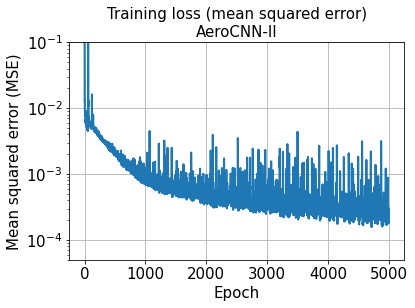

In [86]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-II', size=15)
plt.xlabel('Epoch', size=15)
plt.ylabel('Mean squared error (MSE)', size=15)
plt.yscale('log')
plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

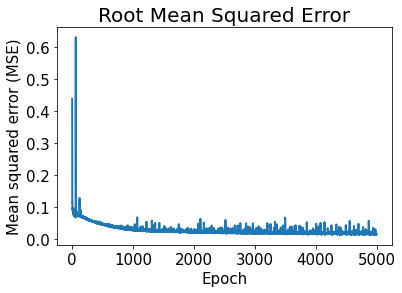

In [89]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=20)
plt.xlabel('Epoch', size=15)
plt.ylabel('Mean squared error (MSE)', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

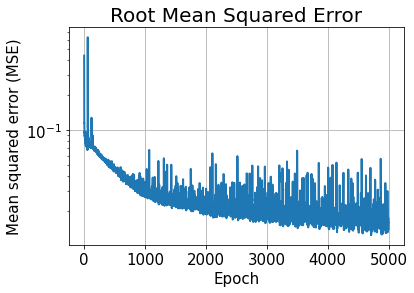

In [88]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=20)
plt.xlabel('Epoch', size=15)
plt.ylabel('Mean squared error (MSE)', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

In [35]:
test_results = model.evaluate(x_train)

63/63 [==============================] - 0s 2ms/step - loss: 3.1035e-06 - rmse: 0.0000e+00


In [36]:
decoded_train = model.predict(x_train)

63/63 [==============================] - 0s 2ms/step


In [37]:
x_train.shape

(2016, 100, 100, 1)

In [38]:
decoded_test = model.predict(x_test)

4/4 [==============================] - 0s 7ms/step


In [39]:
error_train_abs = np.abs(decoded_train - y_train)

In [40]:
error_test_abs = np.abs(decoded_test - y_test)

In [41]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [42]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [43]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [44]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [45]:
decoded_train.shape

(2016, 2, 1)

In [46]:
os.chdir("D:\\TrainedModels\\20221005")
model.save('AeroCNN-II_25kernel_2by2MaxPooling_2CNNlayer_testSize0.05.h5', overwrite=True, include_optimizer=True, save_format='h5')

In [47]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.02657287197977109


In [48]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.15766296448008105


In [49]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

0.024115897845493985


In [125]:
np.sum((decoded_test[:,0,:]-y_test[:,0,:])**2)/112

0.012625861947245697

In [109]:
print(y_train[:,0,:].shape)
print(y_test[:,0,:].shape)

(2016, 1)
(112, 1)


In [123]:
(y_train[:,0,:]**2).shape

(2016, 1)

In [110]:
print(np.sum(y_train[:,0,:]**2))
print(np.sum(y_test[:,0,:]**2))

1079.371519111567
60.289938139134605


In [118]:
tt = y_test[:,0,:]-decoded_test[:,0,:]
tt.shape

(112, 1)

In [119]:
tt2=tt**2
tt2.shape

(112, 1)

In [121]:
print(np.max(tt2))
print(np.min(tt2))
print(np.mean(tt2))

0.22537682119733748
4.602816142861244e-07
0.012625861947245697


In [120]:
np.sum(tt2)

1.414096538091518

In [117]:
print(np.sum((y_train[:,0,:]-decoded_train[:,0,:])**2))
print(np.sum((y_test[:,0,:]-decoded_test[:,0,:])**2))

0.6277371414722742
1.414096538091518


In [113]:
print(0.6277371414722742/1079.371519111567)
print(1.414096538091518/60.289938139134605)

0.0005815765288943014
0.023454934301443884


In [114]:
print(np.sqrt(0.0005815765288943014))
print(np.sqrt(0.023454934301443884))

0.024115897845493985
0.15315003852903167


In [116]:
print(np.sqrt(0.6277371414722742/60.289938139134605))
print(np.sqrt(1.414096538091518/1079.371519111567))

0.1020390704351555
0.03619545599983362


In [50]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

0.06304657842279592


In [51]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

0.15315003852903167


In [52]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

0.24910546282548088


In [53]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.04408116251741443, 0.016853730579400816, 0.010232156457835378, 0.03531586631671522, 0.14879397806884842, 0.6418266808002095, 0.11442877901780649, 0.016123602544905257, 0.03276805786751482, 0.03656289137870365, 0.09423669796689128, 0.017751311883173884, 0.028693073997341646, 0.024973753155555833, 0.01622936978669218, 0.019901815872808114, 0.01224230580089902, 0.007477109295333528, 0.022770184285809895, 0.0530797968409375, 0.1441310122645186, 0.30120752930695266, 0.011883773020867034, 0.047578763570145635, 0.019899570685385178, 0.010023828854761963, 0.07761003242499591, 0.06059626605792032, 0.01464532309984729, 0.1421854172987084, 0.07812214734618772, 0.07215510172314533, 0.04065750162060749, 0.03765287309696829, 0.031618620348355844, 0.020327073372801843, 0.06602187703239741, 0.101209871099736, 0.017015567022926413, 0.018122463686816005, 0.04414485468152805, 0.023922071056464354, 0.006081967163974867, 0.010983056896293262, 0.016364315665084114, 0.008425493097746742, 0.018545574161966

In [54]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.044793650930407415, 0.02801452525841046, 0.05617559066088872, 0.0682794150929486, 0.1503581994470679, 0.6870476062936881, 0.1330803796900626, 0.07302147072420025, 0.04495223813419386, 0.04670102074648182, 0.3223513299347678, 0.054042594369885094, 0.16979127861076096, 0.2657273491977763, 0.12333710426313836, 0.01718042996533286, 0.059637023753111446, 0.035489458549367255, 0.05715355339648396, 0.05495012936149349, 0.39574874484628786, 0.29724271606223146, 0.023462158304764596, 0.029073498237789364, 0.014140785931471592, 0.013307090320460386, 0.014226681631327396, 0.014306623301079388, 0.04666708675353336, 0.03452316314626831, 0.19887208215212854, 0.34938333839639846, 0.016352113555661806, 0.06109969621705374, 0.04437292126596023, 0.2434343372859209, 0.3791121247027584, 1.0825122853047946, 0.2000652504356276, 0.2677869144227021, 0.1509020036174129, 0.18920600760366055, 0.959895516957232, 0.30241860450985336, 0.009323096975575231, 0.3038725173714136, 0.16869138494969907, 0.0766887716740

In [55]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

[0.022976731932241885, 0.01567033368022866, 0.006908572509129488, 0.010184979054966743, 0.14926994261568693, 0.6596177966481251, 0.11454836666415534, 0.0007690119093318751, 0.009602007147712867, 0.020388223398922226, 0.061630074096459216, 0.005338684627363023, 0.028725950239003865, 0.005199304791325276, 0.014713738374070855, 0.020054364257499756, 0.00891769938452169, 0.006348990956224303, 0.018944382811207253, 0.04686106070144236, 0.14261867840453085, 0.3048141989126578, 0.0034351904935212914, 0.045508513370758306, 0.01555269307426383, 0.004083846566090491, 0.07652148929576609, 0.062061337995134525, 0.014194132053876618, 0.1429718647683227, 0.08134399066228172, 0.07348483503448448, 0.03931512857711712, 0.01731871461614034, 0.026041852051072296, 0.0202948224964719, 0.06793992033986135, 0.09499920879911386, 0.010690620671015241, 0.0037656078581570643, 0.012570129348928188, 0.01762261486447298, 0.0030354631640466707, 0.010924510757258095, 0.01567203262493756, 0.007059505565851417, 0.01969

In [56]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

[0.1683460575051331, 0.03969063253234567, 0.09684135080011311, 0.7585618785771683, 0.049441532173081684, 0.013884242941732492, 0.049823000228733864, 0.4999943231818399, 1.1246109551974237, 0.6925973511170201, 0.6687364248744371, 0.0745581648889471, 0.028275929834080712, 0.07936183258117442, 0.025093881468705125, 0.018671049234406052, 0.04016068904485836, 0.0977295001928138, 0.373917775621387, 0.5696558565578393, 0.2577190696845151, 0.2118986540556074, 0.2135950110992755, 0.41463705918652083, 0.41893473662430775, 0.20970935456362313, 0.10069358400649628, 0.022590813369898183, 0.019025956735738002, 0.13458109383878272, 0.04093795762402624, 0.06390855156546141, 0.0605463353965391, 0.24182976655085145, 0.41304236508959713, 0.02790503800414023, 0.0379992919026336, 0.4448935955209585, 0.3548438114566787, 0.6696528733906674, 1.8690901017175485, 0.735192428390655, 0.21878862310488129, 0.03873316252295379, 0.024887506268908906, 0.01725046296157715, 0.003582198161756476, 0.014805347539084279, 0.

In [57]:
np.sqrt(np.sum((decoded_train[:,1,:][36] - y_train[:,1,:][36])**2) / np.sum(y_train[:,1,:][36]**2))

0.0379992919026336

In [58]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

[0.040258807382656546, 0.028340964402874418, 0.04560186019761765, 0.06561464344493759, 0.150185202339562, 0.6902514961424429, 0.1312398421498995, 0.06816495534027923, 0.04490542527872413, 0.04335252017685613, 0.3268878217475158, 0.05061729685761399, 0.17249434994869534, 0.27788736901817024, 0.12663055741653934, 0.016921579658304278, 0.051454963559122734, 0.03290526787536917, 0.05061077464219115, 0.054336041383058184, 0.43634332446246094, 0.2981252502421597, 0.02345493434642949, 0.028372140112180862, 0.0115443513002328, 0.013134659979960661, 0.014210900028346221, 0.01161339280712012, 0.04654298325711854, 0.018724811880989074, 0.20111615470560518, 0.37778347647451466, 0.012563072989757005, 0.0609175721951088, 0.04154534317853241, 0.2420400122668698, 0.3797472146850144, 1.1021437911416485, 0.1998880847157235, 0.2662916195556323, 0.1503833148936272, 0.18930691038905853, 0.9658846517070923, 0.30276225148788694, 0.007915743963994012, 0.31187283762677714, 0.169409058338086, 0.0729502439362451

In [59]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

[0.09684720528335491, 0.011605137426234244, 0.44092623415988524, 0.364673984707276, 0.1661010943402446, 0.596786400230768, 0.46946020900628427, 0.7570648054682274, 0.06694056541656718, 0.24627400120155263, 0.10670966375557127, 0.0969363105994202, 0.13037969631108942, 0.08315141244535712, 0.09122599971619103, 0.01877884920959299, 0.9211685632096518, 0.39618414240658534, 0.6391612878533259, 0.12632181974201495, 0.3538845925059655, 0.05476003694124868, 0.027764165014710636, 0.22668264762824694, 0.3352427174223523, 0.09007992871930737, 0.029043445832557992, 0.24883234110547248, 0.0795527661117687, 0.29324601580206666, 0.13505408818308223, 0.09356834163183346, 0.04743106686668163, 0.06803559894619494, 0.24238021445225422, 0.6082710991776417, 0.29715485988470125, 0.3571516613857677, 0.26237086323637404, 0.9130367292368577, 0.4448253075947942, 0.13802773256623116, 0.2092600092903942, 0.29568064238975894, 0.02065060432212019, 0.18886326000603304, 0.16224031357343183, 0.0992647476202814, 0.0351

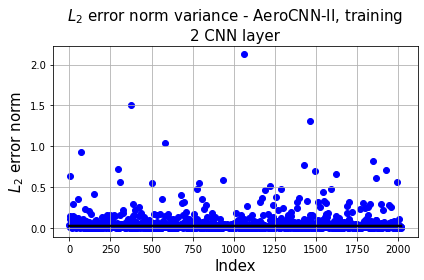

In [164]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, training\n2 CNN layer', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

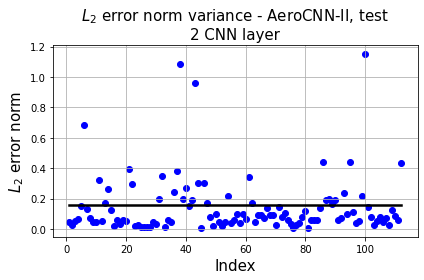

In [163]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, test\n2 CNN layer', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

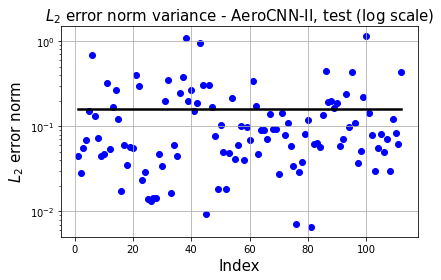

In [62]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, test (log scale)\n2 CNN layer', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

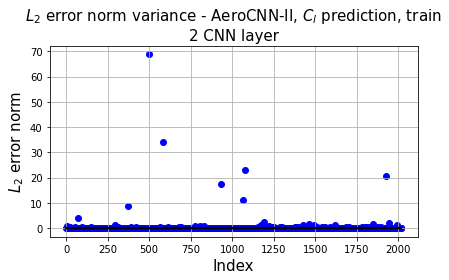

In [161]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train\n2 CNN layer', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

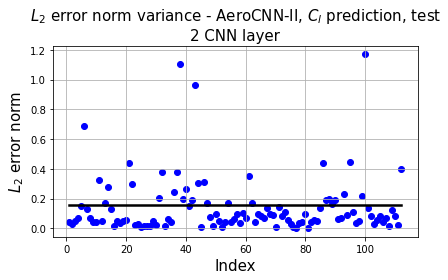

In [162]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test\n2 CNN layer', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

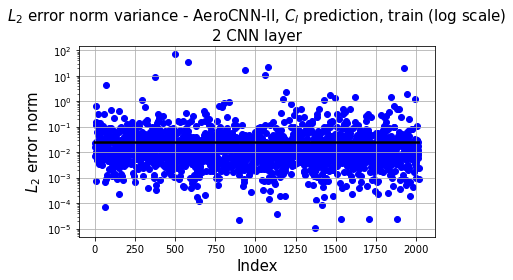

In [155]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train (log scale)\n2 CNN layer', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

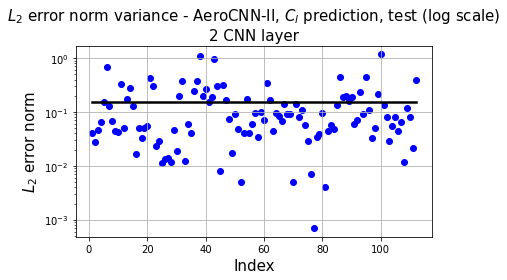

In [156]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test (log scale)\n2 CNN layer', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

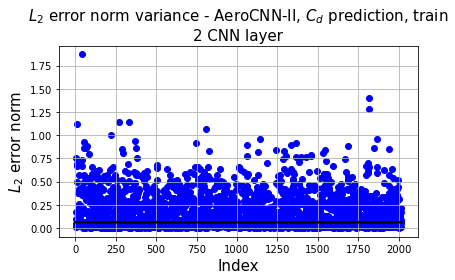

In [157]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, train\n2 CNN layer', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

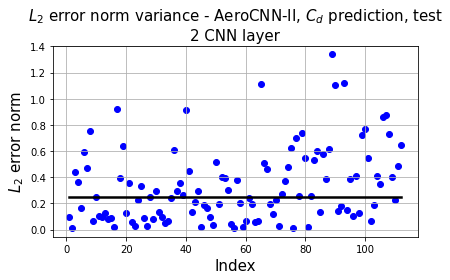

In [158]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, test\n2 CNN layer', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

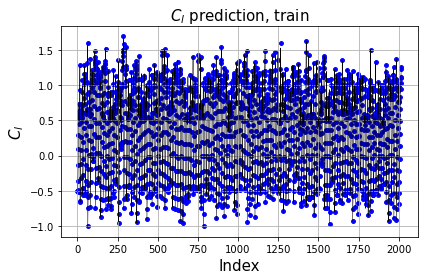

In [69]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

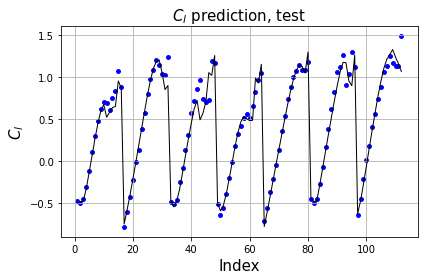

In [70]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

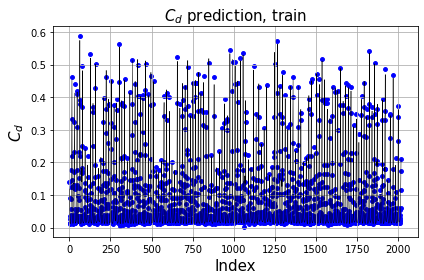

In [71]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

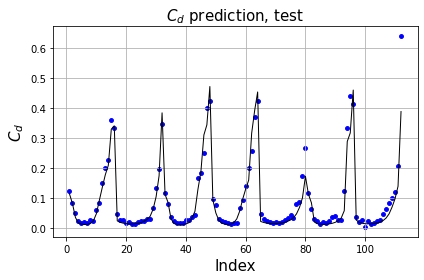

In [72]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

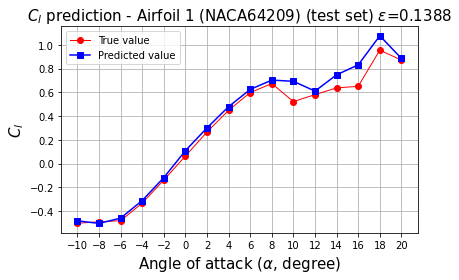

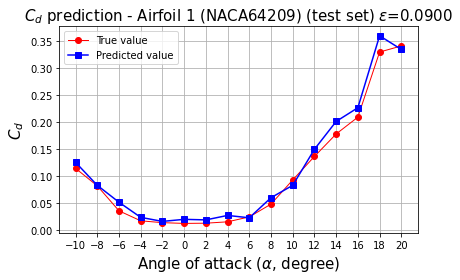

In [90]:
airfoiltest1_predict = decoded_test[16*0:16*1]

airfoiltest1_cl=y_test[16*0:16*1,0,:]
airfoiltest1_cd=y_test[16*0:16*1,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

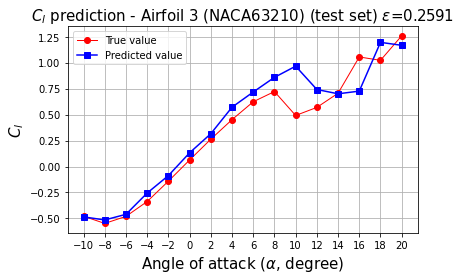

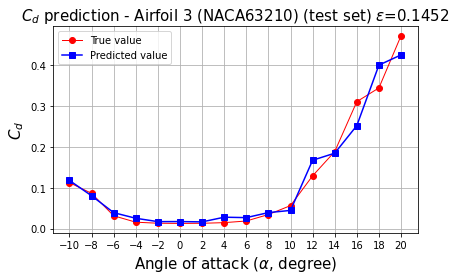

In [91]:
airfoiltest37_predict = decoded_test[16*2:16*3]

airfoiltest37_cl=y_test[16*2:16*3,0,:]
airfoiltest37_cd=y_test[16*2:16*3,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest37_predict[:,0,:] - airfoiltest37_cl)**2) / np.sum(airfoiltest37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest37_predict[:,1,:] - airfoiltest37_cd)**2) / np.sum(airfoiltest37_cd**2))

plt.plot(alpha, airfoiltest37_cl.reshape(16,), 'r', marker='o',lw=1)
plt.plot(alpha, airfoiltest37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

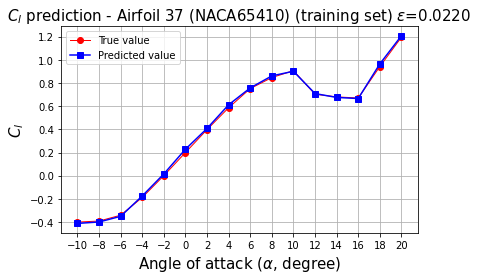

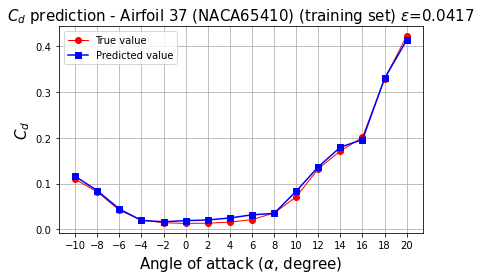

In [77]:
airfoiltrain37_predict = decoded_train[16*36:16*37]

airfoiltrain37_cl=y_train[16*36:16*37,0,:]
airfoiltrain37_cd=y_train[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain37_predict[:,0,:] - airfoiltrain37_cl)**2) / np.sum(airfoiltrain37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain37_predict[:,1,:] - airfoiltrain37_cd)**2) / np.sum(airfoiltrain37_cd**2))

plt.plot(alpha, airfoiltrain37_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

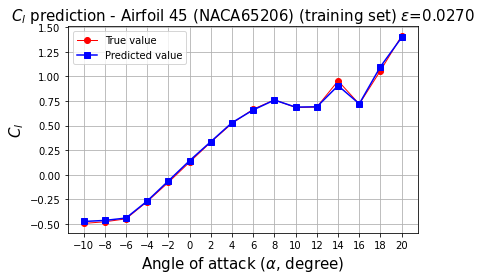

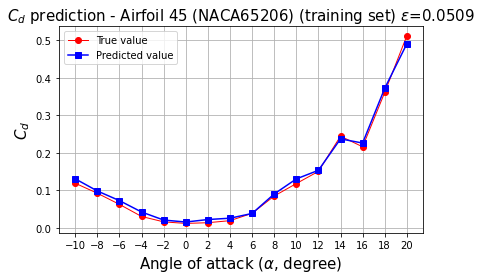

In [78]:
airfoiltrain45_predict = decoded_train[16*44:16*45]

airfoiltrain45_cl=y_train[16*44:16*45,0,:]
airfoiltrain45_cd=y_train[16*44:16*45,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain45_predict[:,0,:] - airfoiltrain45_cl)**2) / np.sum(airfoiltrain45_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain45_predict[:,1,:] - airfoiltrain45_cd)**2) / np.sum(airfoiltrain45_cd**2))

plt.plot(alpha, airfoiltrain45_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCl),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain45_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCd),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

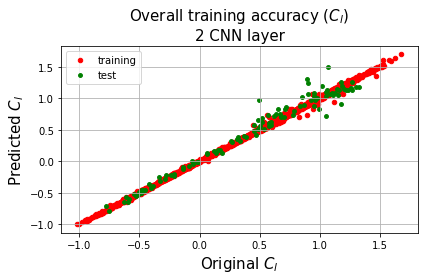

In [159]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='g', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)\n2 CNN layer', fontsize=15)

plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

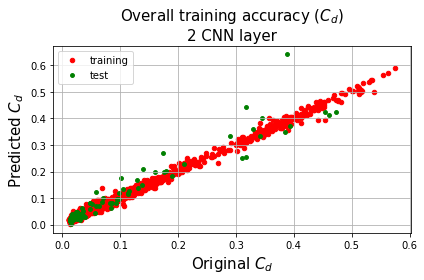

In [160]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='g', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)\n2 CNN layer', fontsize=15)
plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

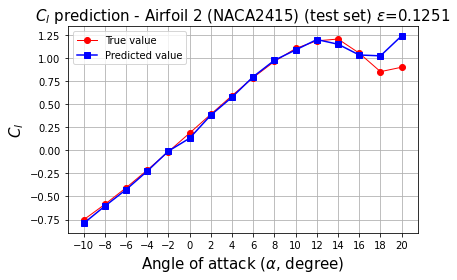

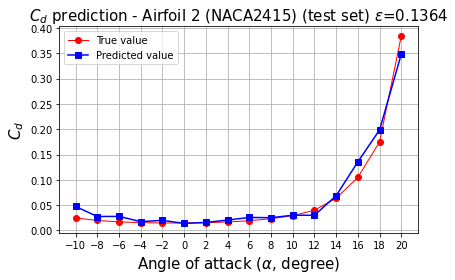

In [92]:
airfoiltest3_predict = decoded_test[16*1:16*2]

airfoiltest3_cl=y_test[16*1:16*2,0,:]
airfoiltest3_cd=y_test[16*1:16*2,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest3_predict[:,0,:] - airfoiltest3_cl)**2) / np.sum(airfoiltest3_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest3_predict[:,1,:] - airfoiltest3_cd)**2) / np.sum(airfoiltest3_cd**2))

plt.plot(alpha, airfoiltest3_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,0,:].reshape(16,), marker='s', c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest3_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,1,:].reshape(16,), marker='s',c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

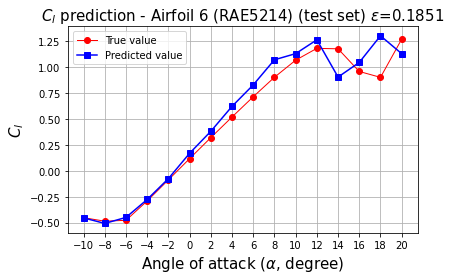

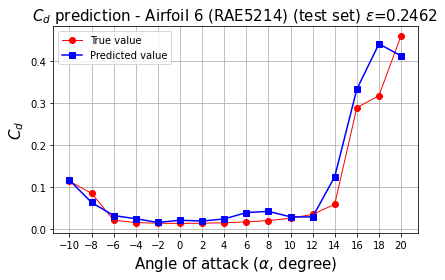

In [93]:
airfoiltest11_predict = decoded_test[16*5:16*6]

airfoiltest11_cl=y_test[16*5:16*6,0,:]
airfoiltest11_cd=y_test[16*5:16*6,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest11_predict[:,0,:] - airfoiltest11_cl)**2) / np.sum(airfoiltest11_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest11_predict[:,1,:] - airfoiltest11_cd)**2) / np.sum(airfoiltest11_cd**2))

plt.plot(alpha, airfoiltest11_cl.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 6 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[5*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest11_cd.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 6 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[5*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

In [94]:
np.sqrt(((1.2-1.3)**2)/(1.3**2))

0.07692307692307698

In [95]:
np.sqrt(((0.07-0.01)**2)/(0.01**2))

6.000000000000001

In [128]:
geometry

array([[[b'NACA0006'],
        [b'NACA0006'],
        [b'NACA0006'],
        ...,
        [b'NACA0006'],
        [b'NACA0006'],
        [b'NACA0006']],

       [[b'NACA0008'],
        [b'NACA0008'],
        [b'NACA0008'],
        ...,
        [b'NACA0008'],
        [b'NACA0008'],
        [b'NACA0008']],

       [[b'NACA000834'],
        [b'NACA000834'],
        [b'NACA000834'],
        ...,
        [b'NACA000834'],
        [b'NACA000834'],
        [b'NACA000834']],

       ...,

       [[b'RAF48'],
        [b'RAF48'],
        [b'RAF48'],
        ...,
        [b'RAF48'],
        [b'RAF48'],
        [b'RAF48']],

       [[b'RAF6'],
        [b'RAF6'],
        [b'RAF6'],
        ...,
        [b'RAF6'],
        [b'RAF6'],
        [b'RAF6']],

       [[b'RAF69'],
        [b'RAF69'],
        [b'RAF69'],
        ...,
        [b'RAF69'],
        [b'RAF69'],
        [b'RAF69']]], dtype='|S32')

In [135]:
geo_train[0,0]

b'NACA1408'

In [140]:
np.where(geo_test[i]=="NACA64a410")

(array([], dtype=int64),)